#### Compare the risk profiles for the ERA5 and hazGAN-generated data

In [30]:
import os
import yaml
from scipy.special import expit
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from regionmask import mask_geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams["font.family"] = ["serif", "sans-serif", "monospace"][0]

wd = "hazGAN2/projects/poweruk_winter"

with open(os.path.join(wd, "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)

regions = ["East Midlands", "West Midlands", "South West England", "South Wales"]
region_of_interest = regions[0]

season = config["sfunc"]
local_crs = config["local_crs"]

datasets = ["training", "generated"]

training = xr.open_dataset(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_training_{season}.nc")
)

generated = xr.open_dataset(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_generated_{season}.nc")
)

gen_ensembles = generated.attrs["n_ensembles"]
ensemble_years = generated.attrs["ensemble_years"]
rp_max = generated.attrs["rp_max"]

In [31]:
def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
    https://tobiasraabe.github.io/post/matplotlib-for-publications/

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    return fig_width_in, fig_height_in

/tmp/ipykernel_3293093/2014189664.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartiles = df.groupby('return_period_center').agg({
/tmp/ipykernel_3293093/2014189664.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartiles = df.groupby('return_period_center').agg({


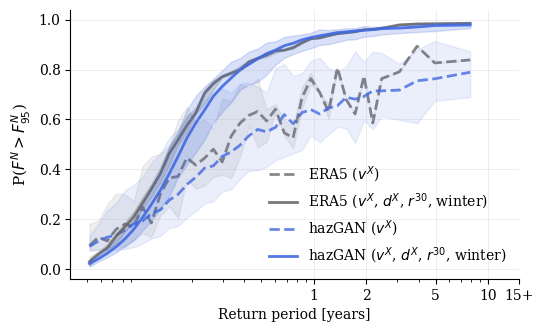

In [34]:
def plot_intervals(ds:xr.Dataset, ax, num_bins=50, color="k", label="", alpha=0.05, interval=True, lw=2):
    
    df = ds.to_dataframe().reset_index()
    bins = np.logspace(
        np.log10(df['return_period'].min()),
        np.log10(df['return_period'].max()),
        num=num_bins
    )
    
    df['return_period_binned'] = pd.cut(df['return_period'], bins=bins)
    df['return_period_center'] = df['return_period_binned'].apply(lambda x: x.mid)

    lower_quantile = lambda x: x.quantile(alpha)
    upper_quantile = lambda x: x.quantile(1-alpha)
    
    quartiles = df.groupby('return_period_center').agg({
        'outage_prob': ['median', lower_quantile, upper_quantile],
        'base_probs': ['median', lower_quantile, upper_quantile]
    }).reset_index()
    
    quartiles.columns = [
        'return_period', # rename return_period_center to just return_period
        'model_median',
        'model_lower',
        'model_upper',
        'base_median',
        'base_lower',
        'base_upper'
    ]
    
    quartiles = quartiles.dropna()

    # plot the baseline
    ax.fill_between(
        quartiles['return_period'], 
        quartiles['base_lower'], 
        quartiles['base_upper'],
        color=color, alpha=0.1,
        zorder=0
    )
    ax.plot(
        quartiles['return_period'],
        quartiles['base_median'],
        color=color, alpha=0.8, linewidth=lw,
        linestyle="--", label=rf"{label}($v^X$)",
        zorder=0
    )
    
    # plot the full model
    ax.fill_between(
        quartiles['return_period'], 
        quartiles['model_lower'], 
        quartiles['model_upper'],
        color=color, alpha=0.2,
        zorder=1
    )
    ax.plot(
        quartiles['return_period'], quartiles['model_median'],
        color=color, alpha=0.9, linewidth=lw,
        label=fr"{label}($v^X$, $d^X$, $r^{{30}}$, {season})",
        zorder=1
    )


fig, ax = plt.subplots(figsize=set_size(500, 0.8))

plot_intervals(training, ax, color="dimgray", num_bins=50, alpha=0.025, label="ERA5 ")
plot_intervals(generated, ax, color="royalblue", num_bins=50, alpha=0.025, label="hazGAN ")

ax.set_xscale("log")
ticks = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000]
ticks = [t for t in ticks if t <= rp_max]
ax.set_xticks(ticks + [rp_max], labels=ticks + [f"{rp_max:.0f}+"])
ax.set_ylabel(r"P($F^N>F^N_{95}$)", fontsize=11)
ax.set_xlabel("Return period [years]")#, fontsize=11)
ax.legend(loc="lower right", frameon=False, )# fontsize=10)
ax.grid(alpha=0.3, linewidth=0.5)
# fig.suptitle(f"{region_of_interest} {gen_ensembles}×{ensemble_years}-year ensembles", y=0.98)

# reduce chartjunk
ax.spines[['right', 'top']].set_visible(False)

fig.tight_layout()

fig.savefig(os.path.join(
    wd, "results", "figures", f"riskprofile_benchmarking_{region_of_interest.lower()}_{season}.pdf"
), dpi=300, transparent=True)

/tmp/ipykernel_3293093/2358273317.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_quartiles = df.groupby('return_period_center').agg({
/tmp/ipykernel_3293093/2358273317.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_quartiles = df.groupby('return_period_center').agg({
/tmp/ipykernel_3293093/2358273317.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_quartiles = df.groupby('return_period_ce

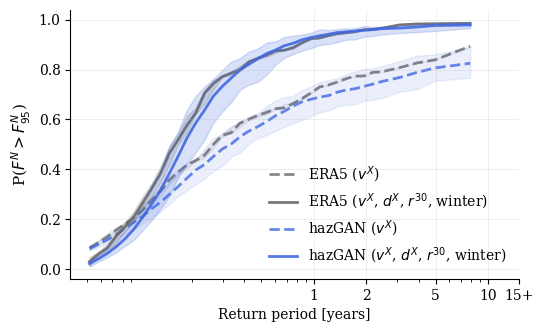

In [37]:
def plot_intervals(ds:xr.Dataset, ax, num_bins=50, color="k", label="", alpha=0.05, interval=True, lw=2):
    
    df = ds.to_dataframe().reset_index()
    bins = np.logspace(
        np.log10(df['return_period'].min()),
        np.log10(df['return_period'].max()),
        num=num_bins
    )
    
    lower_quantile = lambda x: x.quantile(alpha)
    upper_quantile = lambda x: x.quantile(1-alpha)

    df['return_period_binned'] = pd.cut(df['return_period'], bins=bins)
    df['return_period_center'] = df['return_period_binned'].apply(lambda x: x.mid)
    
    model_quartiles = df.groupby('return_period_center').agg({
        'outage_prob': ['median', lower_quantile, upper_quantile]
    }).reset_index()
    
    model_quartiles.columns = [
        'return_period', # rename return_period_center to just return_period
        'median',
        'lower',
        'upper'
    ]

    df['return_period_binned'] = pd.cut(df['base_return_period'], bins=bins)
    df['return_period_center'] = df['return_period_binned'].apply(lambda x: x.mid)

    base_quartiles = df.groupby('return_period_center').agg({
        'base_probs': ['median', lower_quantile, upper_quantile]
    }).reset_index()
    
    base_quartiles.columns = [
        'return_period', # rename return_period_center to just return_period
        'median',
        'lower',
        'upper'
    ]
    
    model_quartiles = model_quartiles.dropna()
    base_quartiles = base_quartiles.dropna()

    # plot the baseline
    ax.fill_between(
        base_quartiles['return_period'], 
        base_quartiles['lower'], 
        base_quartiles['upper'],
        color=color, alpha=0.1,
        zorder=0
    )
    ax.plot(
        base_quartiles['return_period'],
        base_quartiles['median'],
        color=color, alpha=0.8, linewidth=lw,
        linestyle="--", label=rf"{label}($v^X$)",
        zorder=0
    )
    
    # plot the full model
    ax.fill_between(
        model_quartiles['return_period'], 
        model_quartiles['lower'], 
        model_quartiles['upper'],
        color=color, alpha=0.2,
        zorder=1
    )
    ax.plot(
        model_quartiles['return_period'], model_quartiles['median'],
        color=color, alpha=0.9, linewidth=lw,
        label=fr"{label}($v^X$, $d^X$, $r^{{30}}$, {season})",
        zorder=1
    )


fig, ax = plt.subplots(figsize=set_size(500, 0.8))

plot_intervals(training, ax, color="dimgray", num_bins=50, alpha=0.025, label="ERA5 ")
plot_intervals(generated, ax, color="royalblue", num_bins=50, alpha=0.025, label="hazGAN ")

ax.set_xscale("log")
ticks = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000]
ticks = [t for t in ticks if t <= rp_max]
ax.set_xticks(ticks + [rp_max], labels=ticks + [f"{rp_max:.0f}+"])
ax.set_ylabel(r"P($F^N>F^N_{95}$)", fontsize=11)
ax.set_xlabel("Return period [years]")#, fontsize=11)
ax.legend(loc="lower right", frameon=False, )# fontsize=10)
ax.grid(alpha=0.3, linewidth=0.5)
# fig.suptitle(f"{region_of_interest} {gen_ensembles}×{ensemble_years}-year ensembles", y=0.98)

# reduce chartjunk
ax.spines[['right', 'top']].set_visible(False)

fig.tight_layout()

fig.savefig(os.path.join(
    wd, "results", "figures", f"riskprofile_benchmarking_{region_of_interest.lower()}_{season}.pdf"
), dpi=300, transparent=True)